Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Epoch 1/30
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 817s 440ms/step - accuracy: 0.0033 - loss: 7.0773 - precision_1: 0.0015 - recall_1: 6.6893e-07 - val_accuracy: 0.0295 - val_loss: 5.9247 - val_precision_1: 1.0000 - val_recall_1: 0.0010 - learning_rate: 1.0000e-05
Epoch 2/30
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 747s 408ms/step - accuracy: 0.0134 - loss: 6.4642 - precision_1: 0.1509 - recall_1: 1.6830e-04 - val_accuracy: 0.1225 - val_loss: 5.1777 - val_precision_1: 0.8333 - val_recall_1: 0.0100 - learning_rate: 1.0000e-05
Epoch 3/30
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 739s 403ms/step - accuracy: 0.0361 - loss: 5.9320 - precision_1: 0.4583 - recall_1: 0.0019 - val_accuracy: 0.2180 - val_loss: 4.5539 - val_precision_1: 0.8873 - val_recall_1: 0.0315 - learning_rate: 1.0000e-05
Epoch 4/30
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 719s 392ms/step - accuracy: 0.0722 - loss: 5.4422 - precision

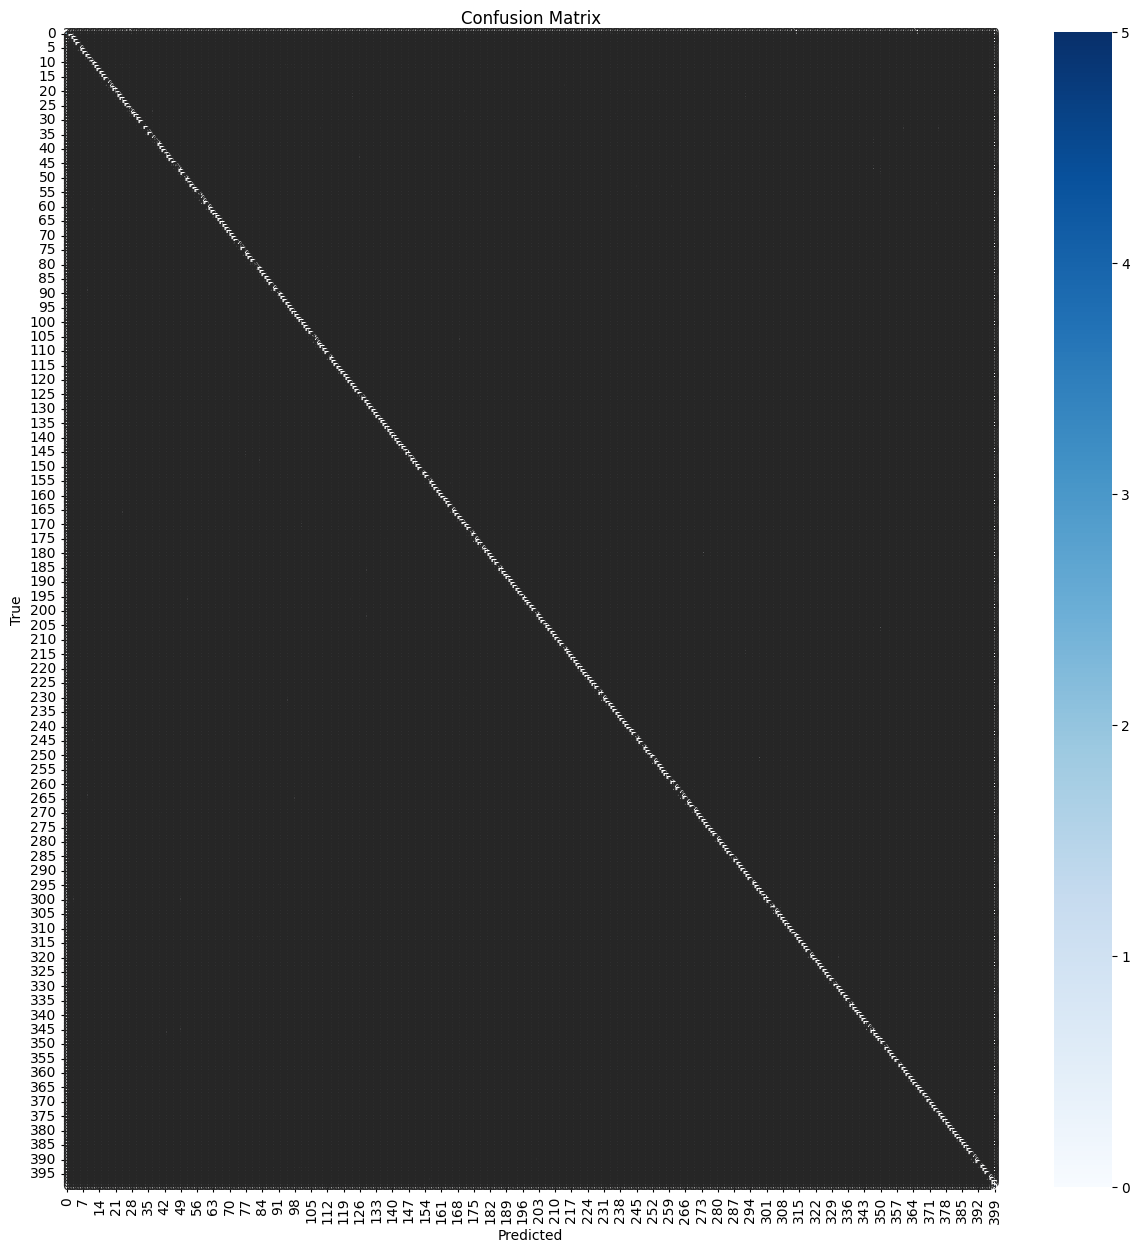

Available metrics: dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1', 'learning_rate'])


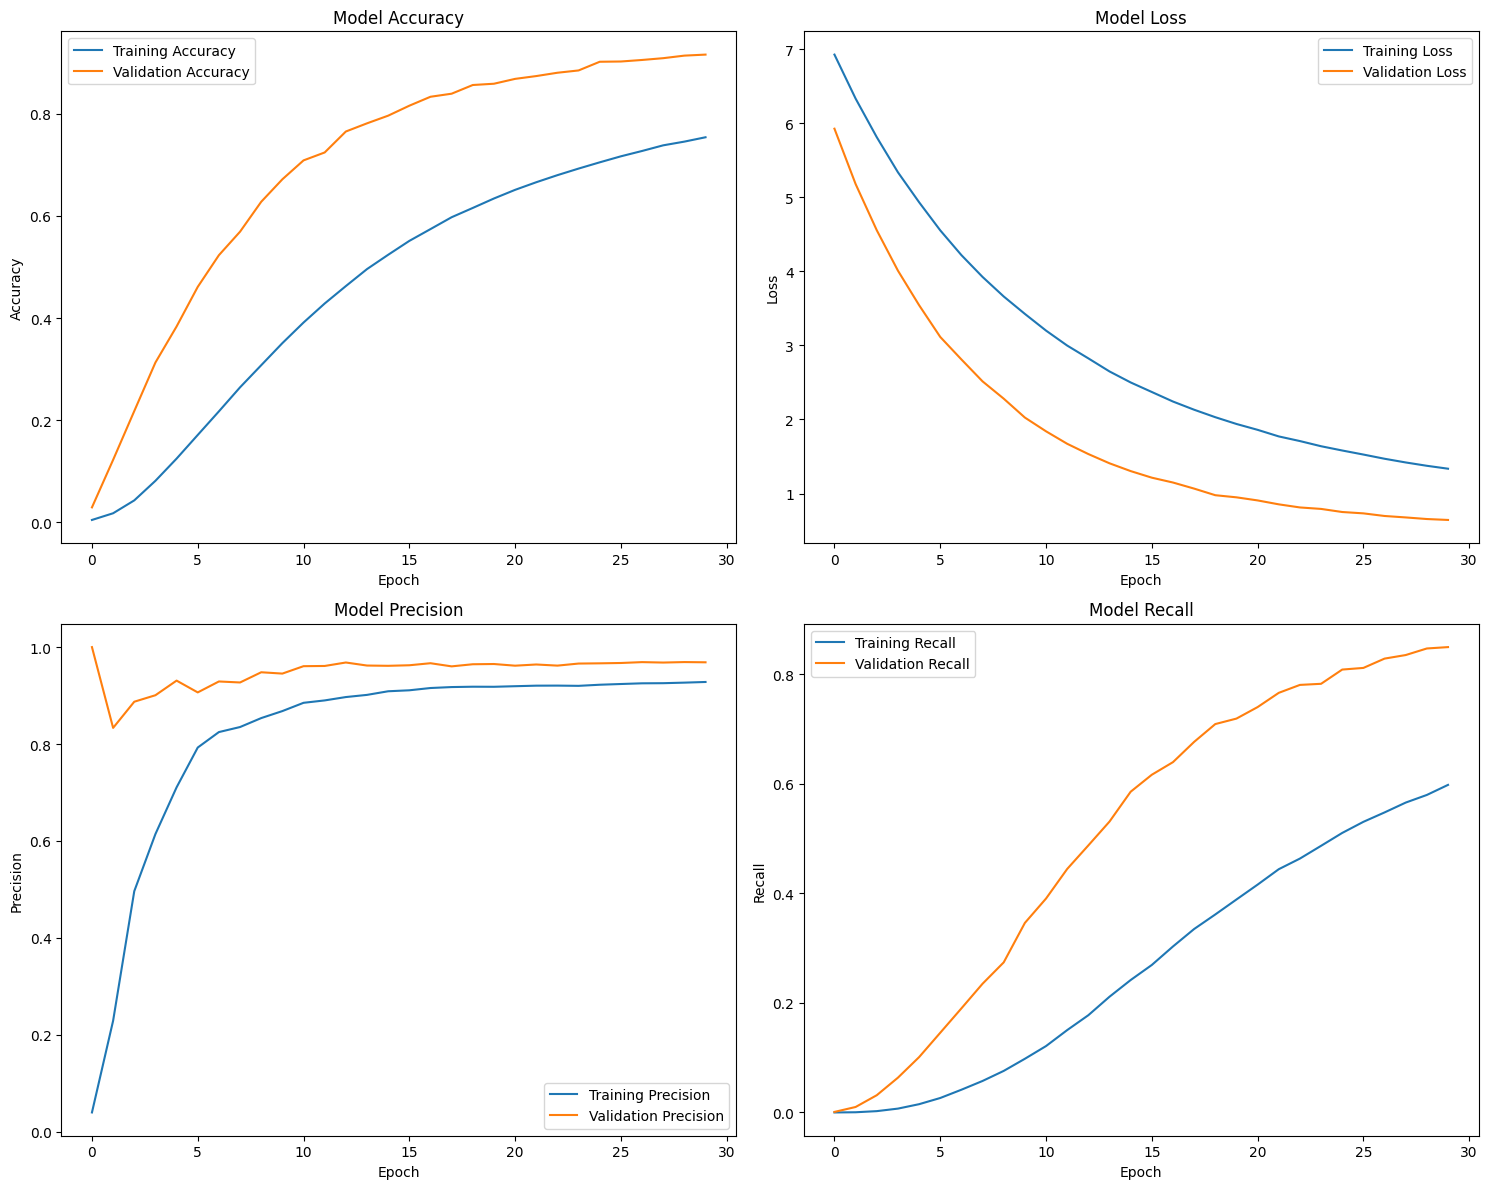

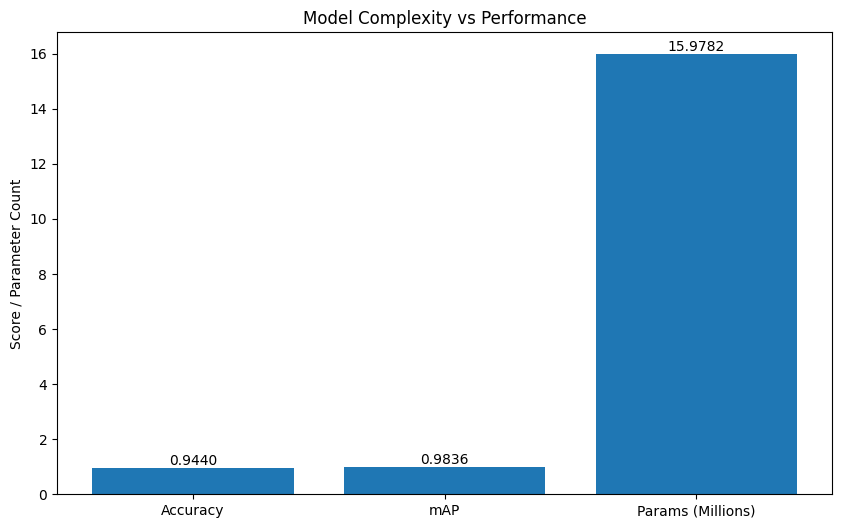


Model Complexity:
Trainable parameters: 8,338,832
Total parameters: 15,978,192

Worst performing classes:
               Class  Precision  Recall        F1
1      ABBOTTS BOOBY       0.50     0.2  0.285714
33          AVADAVAT       0.50     0.2  0.285714
0    ABBOTTS BABBLER       1.00     0.4  0.571429
375   TURKEY VULTURE       0.60     0.6  0.600000
22     ANDEAN SISKIN       0.75     0.6  0.666667

Correct Predictions:
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


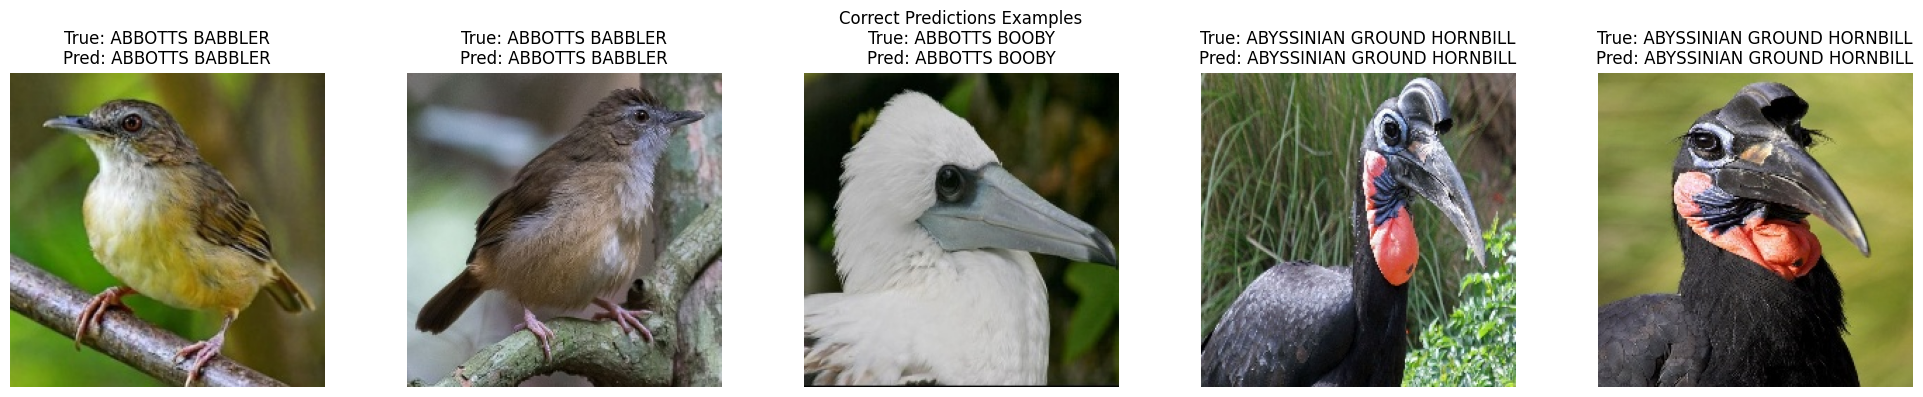


Incorrect Predictions:
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


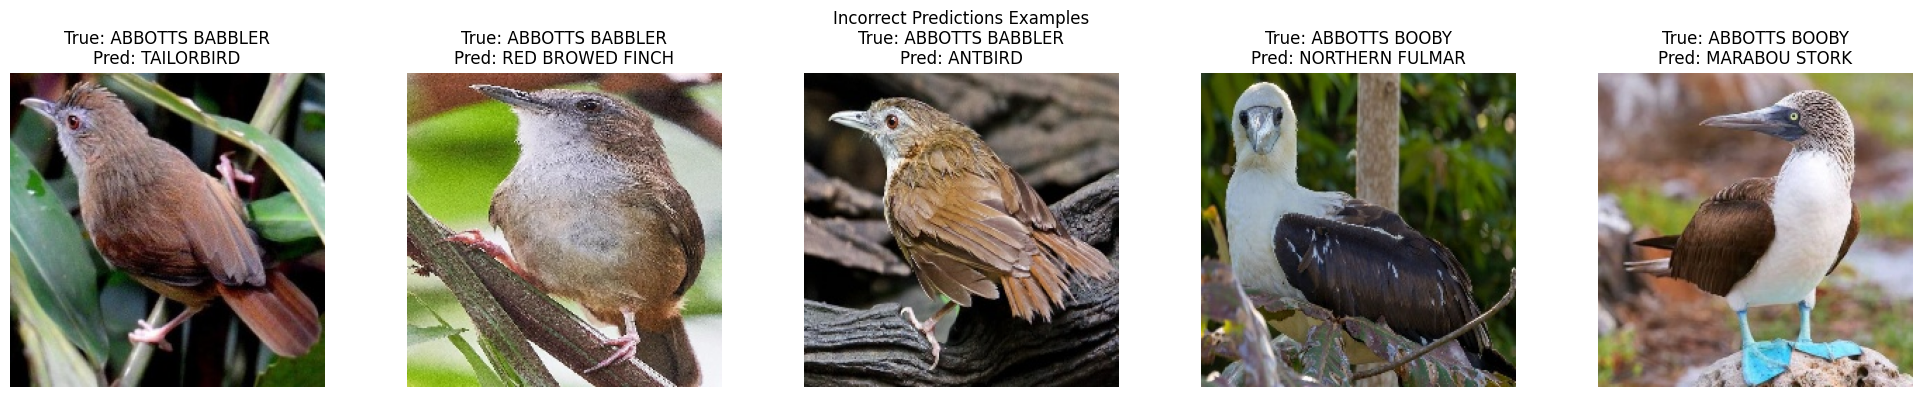

In [3]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support, 
                           average_precision_score, precision_recall_curve)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Add mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Set paths
BASE_PATH = '/kaggle/input/400birds/400BirdSpecies'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Enhanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

n_classes = len(train_generator.class_indices)

# Create model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Reduced dense layer sizes
x = Dense(1024, activation='relu',  # Changed from 2048
          kernel_initializer='he_normal',  # Added initialization
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)  # Reduced regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu',  # Changed from 1024
          kernel_initializer='he_normal',
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Compile model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]

)

# Enhanced evaluation functions
def plot_metrics(history):
    # Print available metrics to debug
    print("Available metrics:", history.history.keys())
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # Precision plot
    ax3.plot(history.history['precision_1'], label='Training Precision')  # Changed from 'precision'
    ax3.plot(history.history['val_precision_1'], label='Validation Precision')  # Changed from 'val_precision'
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Recall plot
    ax4.plot(history.history['recall_1'], label='Training Recall')  # Changed from 'recall'
    ax4.plot(history.history['val_recall_1'], label='Validation Recall')  # Changed from 'val_recall'
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    

def plot_complexity_vs_performance(model, accuracy, map_score):
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    total_params = model.count_params()
    
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'mAP', 'Params (Millions)']
    values = [accuracy, map_score, total_params/1e6]
    
    plt.bar(metrics, values)
    plt.title('Model Complexity vs Performance')
    plt.ylabel('Score / Parameter Count')
    
    for i, v in enumerate(values):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
    
    plt.show()
    
    print(f"\nModel Complexity:")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Total parameters: {total_params:,}")

def evaluate_model():
    # Get predictions and measure inference time
    start_time = time.time()
    predictions = model.predict(test_generator)
    inference_time = time.time() - start_time
    
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Convert to one-hot encoding for MAP calculation
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = np.mean(y_pred == y_true)
    map_score = average_precision_score(y_true_one_hot, predictions, average='macro')
    
    # Print metrics
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {inference_time/len(test_generator):.4f} seconds")
    
    # Confusion Matrix
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot all metrics
    plot_metrics(history)
    plot_complexity_vs_performance(model, accuracy, map_score)

    per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(n_classes)
    )
    
    # Print per-class metrics for worst performing classes
    class_names = list(test_generator.class_indices.keys())
    class_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': per_class_precision,
        'Recall': per_class_recall,
        'F1': per_class_f1
    })
    
    print("\nWorst performing classes:")
    print(class_metrics.nsmallest(5, 'F1'))

def show_prediction_examples(correct=True):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    mask = y_pred == y_true if correct else y_pred != y_true
    indices = np.where(mask)[0][:5]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, idx in enumerate(indices):
        batch_idx = idx // test_generator.batch_size
        in_batch_idx = idx % test_generator.batch_size
        batch = test_generator[batch_idx]
        image = batch[0][in_batch_idx]
        
        true_class = list(test_generator.class_indices.keys())[y_true[idx]]
        pred_class = list(test_generator.class_indices.keys())[y_pred[idx]]
        
        axes[i].imshow(image)
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}')
        axes[i].axis('off')
    
    status = "Correct" if correct else "Incorrect"
    plt.suptitle(f'{status} Predictions Examples')
    plt.tight_layout()
    plt.show()

# Evaluate model and show all metrics
evaluate_model()

# Show prediction examples
print("\nCorrect Predictions:")
show_prediction_examples(correct=True)
print("\nIncorrect Predictions:")
show_prediction_examples(correct=False)

# Save model
model.save('bird_classification_model.h5')



